

# INF161: Course Project
### *Predicting Soccer Scores for the Norwegian Women's Soccer Championships*



> #### by [Sebastian Einar Salas Røkholt](https://www.linkedin.com/in/sebastianrokholt/)
>-------------------------------------------
> *Autumn 2021* 

----------------------------------------------------------------------------
<a id="top"></a> 

<h2> Part 2: Exploratory Data Analysis, Modelling and Prediction</h2>
        

### Analysis and Modelling Notebook Index:
1. [**Exploratory Data Analysis**](#analysis) <br>
    1.1       [*Splitting the Dataset*](#splitting)<br>
    1.2       [*Exploring the games data*](#EDA_games)<br>
    1.3       [*Analysing the effect of scaling the data*](#scaling-analysis)<br>
    1.4       [*Correlation Analysis*](#correlation-analysis)<br>
    1.5       [*Feature importance*](#feature-importance)<br>
    1.6       [*Analysing the effect of PCA*](#pca-effect)<br>
<div>
<img src="soccer-analytics.webp" alt="Soccer analytics icon" align="right" width="300" height="300"/>
</div>

2. [**Modelling: First Iteration**](#1st-iteration)<br>
    2.1       [*Scaling the data*](#scaling)<br>
    2.2       [*Calculating the principal components*](#pca)<br>
    2.3       [*Baseline Model*](#baseline)<br>
    2.4       [*Linear Regression*](#linear_regression)<br>
    2.5       [*K Nearest Neighbours*](#knn)<br>
    2.6       [*Support Vector Machines*](#svm)<br>
    2.7       [*Tree-based models*](#trees)<br>
    2.8       [*Multilayer Perceptron*](#mlp)<br>
3. [**Feature Engineering**](#feature-engineering)<br>
    3.1       [*Adding sample weights*](#sample_weights) <br>
    3.2       [*Re-training the Random Forest model with sample weights*](#weighted_rf)<br>
    3.3       [*Re-training the ElasticNet model with sample weights*](#weighted_en)<br>
5. [**Final Test and Evaluation**](#test)
6. [**Predicting Scores for the 2020 Season**](#predict)

In [1]:
# Importing notebook dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from math import sqrt, ceil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import defaultdict
import warnings
import pickle
import copy

# Setting options
plt.style.use('ggplot')
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting random state for all estimators and functions that use randomization
random_state = 42

## <a id="analysis"></a>1) Exploratory Data Analysis

This section will investigate interesting attributes, relationships and correlations in the training data, as well as the effect of different preprocessing techniques. The insights gained through exploratory data analysis (EDA) will help me pick appropriate preprocessing techniques and machine learning algorithms. It will also be valuable for reflecting on the results from the modelling process.

The EDA will be performed on the training data, as I don't want the validation or test data to influence the preprocessing or modelling decisions I make. I will therefore only be able to analyse the data from the 2017 and 2018 season, with the (perhaps flawed) assumption that the 2019 and 2020 seasons share the same attributes. However, since the validation set consists of 50% of the 2019 data, I am hoping that the tuned models will be able to generalise even if there are some significant differences between the seasons.

In [2]:
# Loading the cleaned data
# games_df = pd.read_csv("games_prepared.csv", encoding="UTF-8")
games_df = pd.read_html("Prepared Data/games_prepared.html", encoding="UTF-8")[0]

games_df.head()

,Date,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
0,2017-04-17,2017,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.0,-0.166667,1.640152,1.640152,21.9,25.0,0,0,1.0,1.0
1,2017-04-17,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,-0.166667,1.640152,1.640152,22.9,25.2,0,0,2.0,2.0
2,2017-04-17,2017,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,-1.833333,1.640152,1.640152,21.9,22.4,0,0,2.0,1.0
3,2017-04-17,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0,1.250000,1.640152,1.640152,25.2,20.1,0,0,1.0,6.0
4,2017-04-17,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.166667,1.640152,1.640152,22.4,21.8,0,0,2.0,3.0


### <a id="splitting"></a>1.1) Splitting the dataset

Since the aim of this project is to predict scores for the 2020 season based on data from 2017-2019, I will be splitting the dataset after which season each game belongs to. Games from the 2017 and 2018 seasons will be part of the training data (2/3rds of the dataset), while the 2019 season will be split randomly into validation (1/6th) and test (1/6th) data.

In [3]:
# Selecting independent (X) and dependent/predictor (y) variables
# Splitting the dataset into training (2/3rds), validation (1/6ths) and test (1/6ths) data
# Final competition prediction set (games_2020) remains unused until after the best model has been evaluated against the test set.

# Training data: data from the 2017 and 2018 seasons, not shuffled
X_train = games_df.loc[games_df["Season"] <= 2018, "Season": "Top 5 Opponent"]
y_train = games_df.loc[games_df["Season"] <= 2018, "y1: Team Score": "y2: Opponent Score"]

# Validation and test data: data from the 2019 season, shuffled randomly
X_valtest = games_df.loc[games_df["Season"] == 2019, "Season": "Top 5 Opponent"]
y_valtest = games_df.loc[games_df["Season"] == 2019, "y1: Team Score": "y2: Opponent Score"]
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, shuffle=True, random_state=random_state)

# Combine training and validation data. Is used for re-training before predicting on test data. 
X_trainval = pd.concat([X_train, X_val.sort_index()])
y_trainval = pd.concat([y_train, y_val.sort_index()])

# Printing the size of the datasets
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_trainval))

# Displaying the first 5 rows of the training data
display(X_train.head(5))
display(y_train.head(5))

528
134
134
662


,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
0,2017,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.0,-0.166667,1.640152,1.640152,21.9,25.0,0,0
1,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,-0.166667,1.640152,1.640152,22.9,25.2,0,0
2,2017,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,-1.833333,1.640152,1.640152,21.9,22.4,0,0
3,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0,1.250000,1.640152,1.640152,25.2,20.1,0,0
4,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.166667,1.640152,1.640152,22.4,21.8,0,0


,y1: Team Score,y2: Opponent Score
0,1.0,1.0
1,2.0,2.0
2,2.0,1.0
3,1.0,6.0
4,2.0,3.0


### <a id="EDA_games"></a>1.2) Exploring the games data

In [4]:
display(X_train.loc[:, 'Avg. Historical Score Diff':].describe())
display(y_train.describe())

,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
count,5.280000e+02,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,-2.312965e-18,1.641333,1.641333,23.368647,23.368647,0.208333,0.208333
std,1.722378e+00,0.432381,0.432381,1.776244,1.776244,0.406502,0.406502
min,-7.000000e+00,0.730000,0.730000,19.800000,19.800000,0.000000,0.000000
25%,-1.000000e+00,1.640114,1.640114,21.900000,21.900000,0.000000,0.000000
50%,0.000000e+00,1.640152,1.640152,23.450000,23.450000,0.000000,0.000000
75%,1.000000e+00,1.650114,1.650114,25.100000,25.100000,0.000000,0.000000
max,7.000000e+00,3.050000,3.050000,26.400000,26.400000,1.000000,1.000000


,y1: Team Score,y2: Opponent Score
count,528.000000,528.000000
mean,1.659091,1.659091
std,1.564936,1.564936
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,9.000000,9.000000


The target features are right-skewed, because it is more common to score few goals than many. There are also a few outliers, which might negatively affect the accuracy of the model. Scoring 9 goals is very rare, but the value is not so high that it will severely impact the model's predictions.

### <a id="scaling-analysis"></a>1.3)  Analysing the effect of scaling the data

Scikit-learn features many different estimators that scale and/or normalise data. In this section, I want to explore how different scalers impact the distribution of the training data. I've selected four features, mainly because I don't want to visualise more than I have to. Most of the features are quite similar, and very many are dummy variables that only contain a 1 or 0, so they aren't particularly interesting to analyse. The four features I decided to use in the visualisation are numerical features that have a wide spread in the original distribution. Some of them also have outliers, which are important to deal with as I will mainly be using linear machine learning algorithms that are sensitive towards outliers.

One of the scalers I have chosen to visualise is MinMaxScaler, which is the simplest scaling alternative. It scales the data to the interval [0, 1] (normalisation) but does not standardise the data to a mean of 0 and standard deviation of 1. MinMaxScaler is quite sensitive towards outliers. RobustScaler, on the other hand, is very robust towards outliers becuase it uses the interquartile range to scale the data instead of the minimum and maximum. The result should therefore look similar to MinMaxScaler, but with outliers mapped to the 25th percentile (lower bound) or the 75th percentile (upper bound). StandardScaler standardises the data so that is follows a Gaussian (normal) distribution. It achieves this by simply removing the mean and scaling the data to unit variance. QuantileTransformer also normalises the data, but uses the quantiles to map outliers to the outer bounds of the normal distribution similarly to RobustScaler. I expect that QuantileTransformer will work best on this dataset, because many of the features aren't normally distributed - which is necessary for many of the machine learning algorithms that I'm going to use. The disadvantage is that QuantileTransformer spreads out the most frequently observed values, so some features might look quite strange as there are only a handful of unique observations. Finally, I want to take a look at PowerTransformer, which is a scaler I haven't used before. Similarly to QuantileTranformer, PowerTransformer normalises the data to a Gaussian distribution, but it uses a more complicated algorithm that uses a likelyhood function. I am curious to see whether the results will be similar to any of the other scalers.

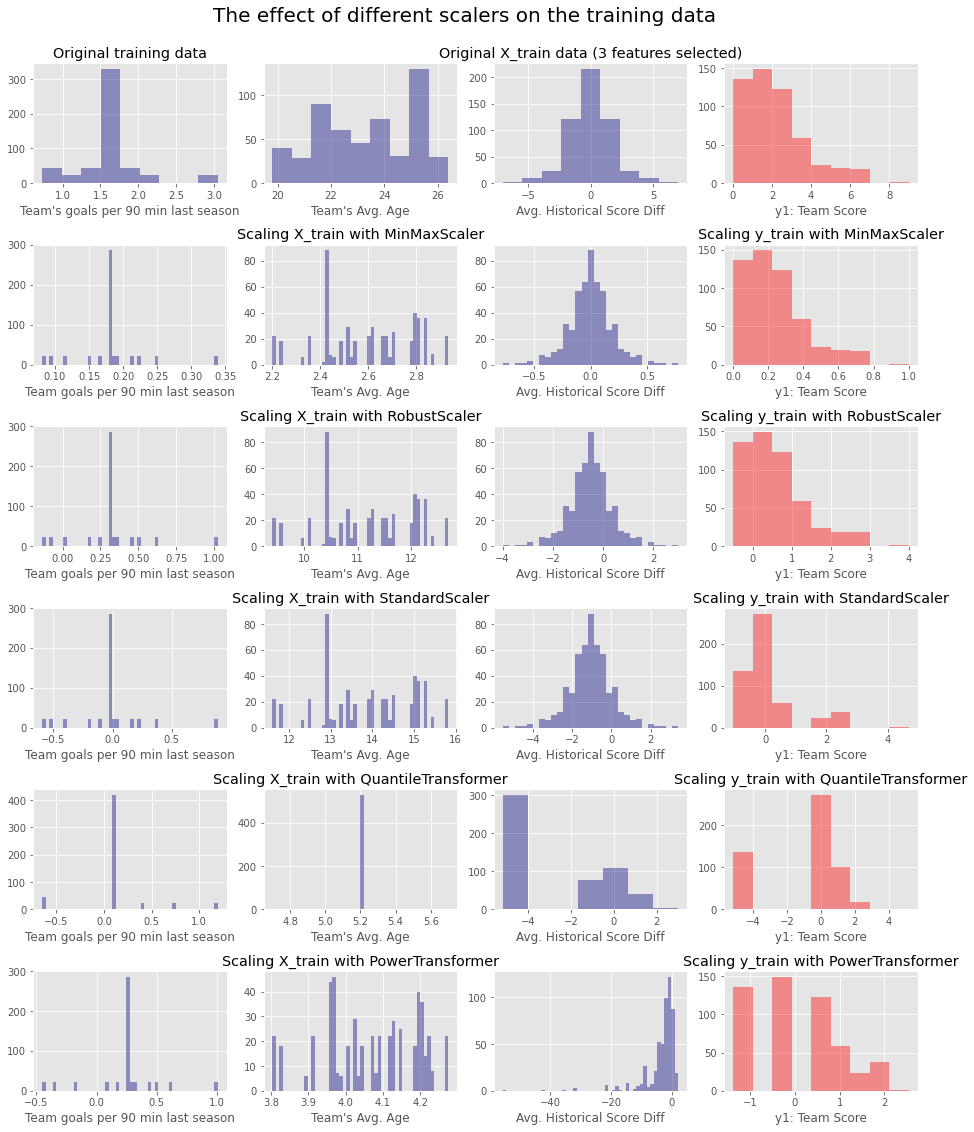

In [5]:
# Visualizing the distribution of the target feature when scaled with QuantileTransformer
scalers = [MinMaxScaler(), RobustScaler(), StandardScaler(), QuantileTransformer(output_distribution='normal'), PowerTransformer(standardize=True)]
X_train_copy = X_train.loc[:, 'Avg. Historical Score Diff':].copy(deep=True)
y_train_copy = y_train["y1: Team Score"].copy(deep=True)
y_val_copy = y_val["y1: Team Score"].copy(deep=True)

# Create a figure with subplots
fig, axes = plt.subplots(6, 4, figsize=(13, 16))

# Plotting the original data
sns.distplot(X_train["Team's goals per 90 min last season"], ax=axes[0, 0], kde=False, bins=9, color='navy')
sns.distplot(X_train["Team's Avg. Age"], ax=axes[0, 1], kde=False, bins=9, color='navy')
sns.distplot(X_train["Avg. Historical Score Diff"], ax=axes[0, 2], kde=False, bins=9, color='navy')
sns.distplot(y_train["y1: Team Score"], ax=axes[0, 3], kde=False, bins=9, color="red")

axes[0, 0].title.set_text(f'Original training data')
axes[0, 2].title.set_text(f'Original X_train data (3 features selected)')

row = 1

for scaler in scalers:
    # Scaling some selected features in training and validation data
    y_train_scaled = scaler.fit_transform(y_train_copy.values.reshape(-1, 1))
    tgls90_scaled = scaler.transform(X_train_copy["Team's goals per 90 min last season"].values.reshape(-1, 1))  # only transform val, no re-fit
    taa_scaled = scaler.transform(X_train_copy["Team's Avg. Age"].values.reshape(-1, 1))
    ahsd_scaled = scaler.transform(X_train_copy["Avg. Historical Score Diff"].values.reshape(-1, 1))
    
    # Plotting the effect of scaling in subplots on a single row
    sns.distplot(tgls90_scaled, ax=axes[row, 0], kde=False, color='navy')
    sns.distplot(taa_scaled, ax=axes[row, 1], bins=50, kde=False, color='navy')
    sns.distplot(ahsd_scaled, ax=axes[row, 2], kde=False, color='navy')
    sns.distplot(y_train_scaled, ax=axes[row, 3], kde=False, bins=9, color="red")
    
    # Formatting subplot: Title, x axis labels
    axes[row, 1].title.set_text(f'Scaling X_train with {scaler.__class__.__name__}')
    axes[row, 3].title.set_text(f'Scaling y_train with {scaler.__class__.__name__}')
    axes[row, 0].set_xlabel('Team goals per 90 min last season', size=12)
    axes[row, 1].set_xlabel("Team's Avg. Age", size=12)
    axes[row, 2].set_xlabel('Avg. Historical Score Diff', size=12)
    axes[row, 3].set_xlabel('y1: Team Score', size=12)

    # Increment "row" so that the next subplot is in the correct position
    row +=1

# Setting plot title and adjusting the layout
fig.suptitle('The effect of different scalers on the training data\n', size=20)
fig.tight_layout()
plt.show()

The results are somewhat disappointing, as neither PowerTransformer nor QuantileTransformer were able to properly normalise all four features. It seems like PowerTransformer is the most effective, but sadly I cannot implement it on the training data due to a [bug](https://github.com/scikit-learn/scikit-learn/issues/14959) with the current version. QuantileTransformer worked well on the target variable but transformed all observations for the team's average ages to a single value. StandardScaler normalised the target variable quite well, but it didn't do that much with the Team Goals per 90 min or the Team's Avg. Age features. MinMaxScaler and RobustScaler performed as expected, and we can clearly see the benefit of using RobustScaler as the outliers are mapped to the upper bound, thus resulting in a less left-skewed distribution. 

In conclusion, I will first use RobustScaler on the data to deal with outliers. I will then use StandardScaler to normalise the data, even though the result won't be perfect. I think the consequence of preprocessing the data like this will be that the predictions will mostly be within the 0-2 range. I don't expect to see any predictions higher than 2, at least not for any team that isn't *LSK Kvinner* or maybe *Grand Bodø*.

### <a id="correlation-analysis"></a> 1.4) Correlation analysis

In [6]:
# Analysing the correlation between the target variables
y_correlations = y_train["y1: Team Score"].corr(y_train["y2: Opponent Score"])
print(y_correlations)

-0.16841586250616342


The target variables are somewhat negatively correlated. This is to be expected, as a high score for a winning team tends to result in a lower score for the losing team, and vice versa. However, there are many matches that either end in a tie, or have a high amount of goals from both sides. We therefore don't see a very high negative correlation, though it is still significant.

The negative correlation between the target variables leads me to believe that a multioutput regression model, such as a tree-based model, will perform well. This is because algorithms that inherently support multi-output regression will be able to predict both target variables simultaneously, instead of having to fit two independent models that predict for each target variable independently. In the latter case, any correlation between the target variables will be lost. A way to mitigate this issue could be to use regressor chaining, so that the result from predicting on the first variable will be used to predict the second variable. However, this will likely not be as effective as predicting with a multioutput model such as Random Forest, because the prediction on the first target variable will still be independent of the second target variable. I therefore expect Random Forest to be the best performing algorithm on this dataset. 

In [7]:
# Calculate the absolute correlation of independent variables with target variable
print("Total number of independent variables: ", len(X_train.columns))
correlations = X_train.corrwith(y_train["y1: Team Score"]).abs().sort_values(ascending=False)
print('\n       FEATURE                 ABS. CORRELATION', 
      '\n|-----------------------------|----------------|')
print(correlations.head(10))
print(f'\nNumber of features with an absolute correlation greater than 0.05:',
      len(correlations[correlations.gt(0.05)]))

Total number of independent variables:  41

       FEATURE                 ABS. CORRELATION 
|-----------------------------|----------------|
Opponent_Grand Bodø                    0.298040
Team_LSK Kvinner                       0.289274
Avg. Historical Score Diff             0.240894
Opponent_Medkila                       0.197021
Opponent_LSK Kvinner                   0.175318
Team_Medkila                           0.166710
Team's goals per 90 min last season    0.145130
Venue_Home                             0.138098
Venue_Away                             0.138098
Opponent_Klepp                         0.122722
dtype: float64

Number of features with an absolute correlation greater than 0.05: 24


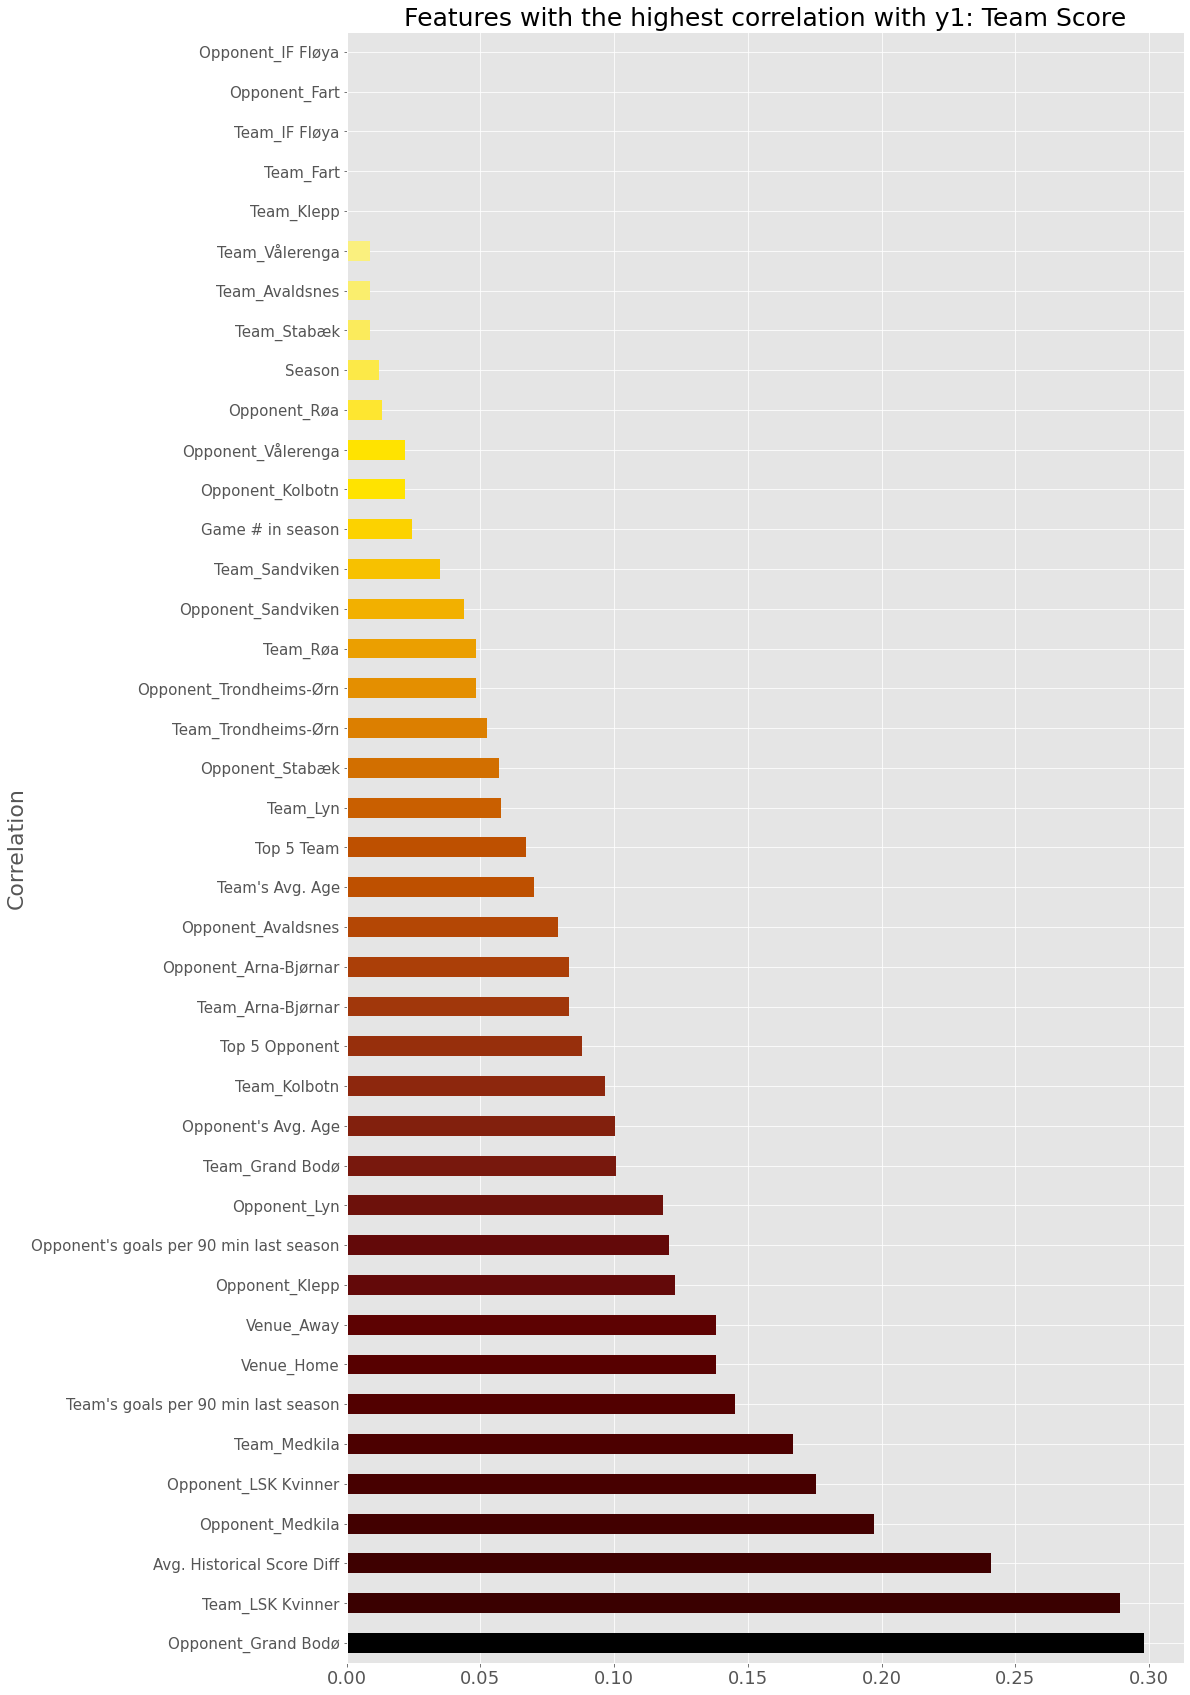

In [8]:
# Visualizing correlation between target feature 'y1: Team Score' and the features with highest correlation
plt.figure(figsize=(15, 30))

# Custom cmap with hexcodes generated with colordesigner.io
cmap = [
    '#000000', '#3a0000', '#3e0000', '#420000', '#470000', 
    '#4c0000', '#520000', '#570000', '#5d0202', '#630909', 
    '#630909', '#6d110b', '#78180d', '#82200d', '#8d270d',
    '#972f0c', '#a1370b', '#ab3f08', '#b44705', '#be5000',
    '#be5000', '#c95f00', '#d26f00', '#dc7f00', '#e48f00',
    '#eb9f00', '#f2b000', '#f7c100', '#fcd200', '#ffe300',
    '#ffe300', '#fee630', '#fce948', '#fbeb5c', '#faee6d',
    '#faf07e', '#f9f28e', '#f9f49d', '#f9f6ac', '#f9f8bb',
        ]

# Calculate the correlation between all features (excluding SALE PRICE) and SALE PRICE,
# and select the 20 features that correlate the most
highest_corr = X_train.corrwith(y_train["y1: Team Score"]).abs().sort_values(ascending=True)[:20]

# Plot the correlations
correlations.sort_values(ascending=False).plot(kind='barh', color=cmap)
# plt.invert_yaxis()
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)
plt.ylabel("Correlation", fontsize=22)
plt.title("Features with the highest correlation with y1: Team Score", size=25)

plt.show()

Firstly, it is interesting to see that the "Season" feature actually correlates with the target variables. I initially decided to remove this feature, as my plan was to train the models on data from a specific season and then predict for the following season(s). However, I have decided that it might be better to keep this feature as I'll be combining the training and validation datasets before making predictions on test data. Since the new training dataset will consist of samples from multiple seasons, the "Season" feature might be significant if one season has a higher number of goals overall than the others. 

Secondly, I have noted that some of the most important features are related to whether the team is a top tier team, or whether they are playing against one. I believe that this is the consequence of using a small dataset. The consequence might be that a few groups of samples in the training data will heavily impact the machine learning models, which could be a problem for the models' ability to generalise. 

Finally I see that the engineered features *Avg. Historical Score Diff*, *Team/Opponent's goals per 90 min last season* and *Team/Opponent's Avg. Age* are highly correlated with the target feature. I think that this is a strong indication that my attempt at feature engineering in Part 1 was successful, as these new features might prove very useful for predicting scores. 

### <a id="feature-importance"></a>1.5) Feature importance
For this section, I will use a simple decision tree model to visualise the most important features. I feel that this is an easy and intuitive way to determine the most important features, as these will occur during the first splits in the tree. It is also easy to visualise with *Sklearn*'s `tree` module. 

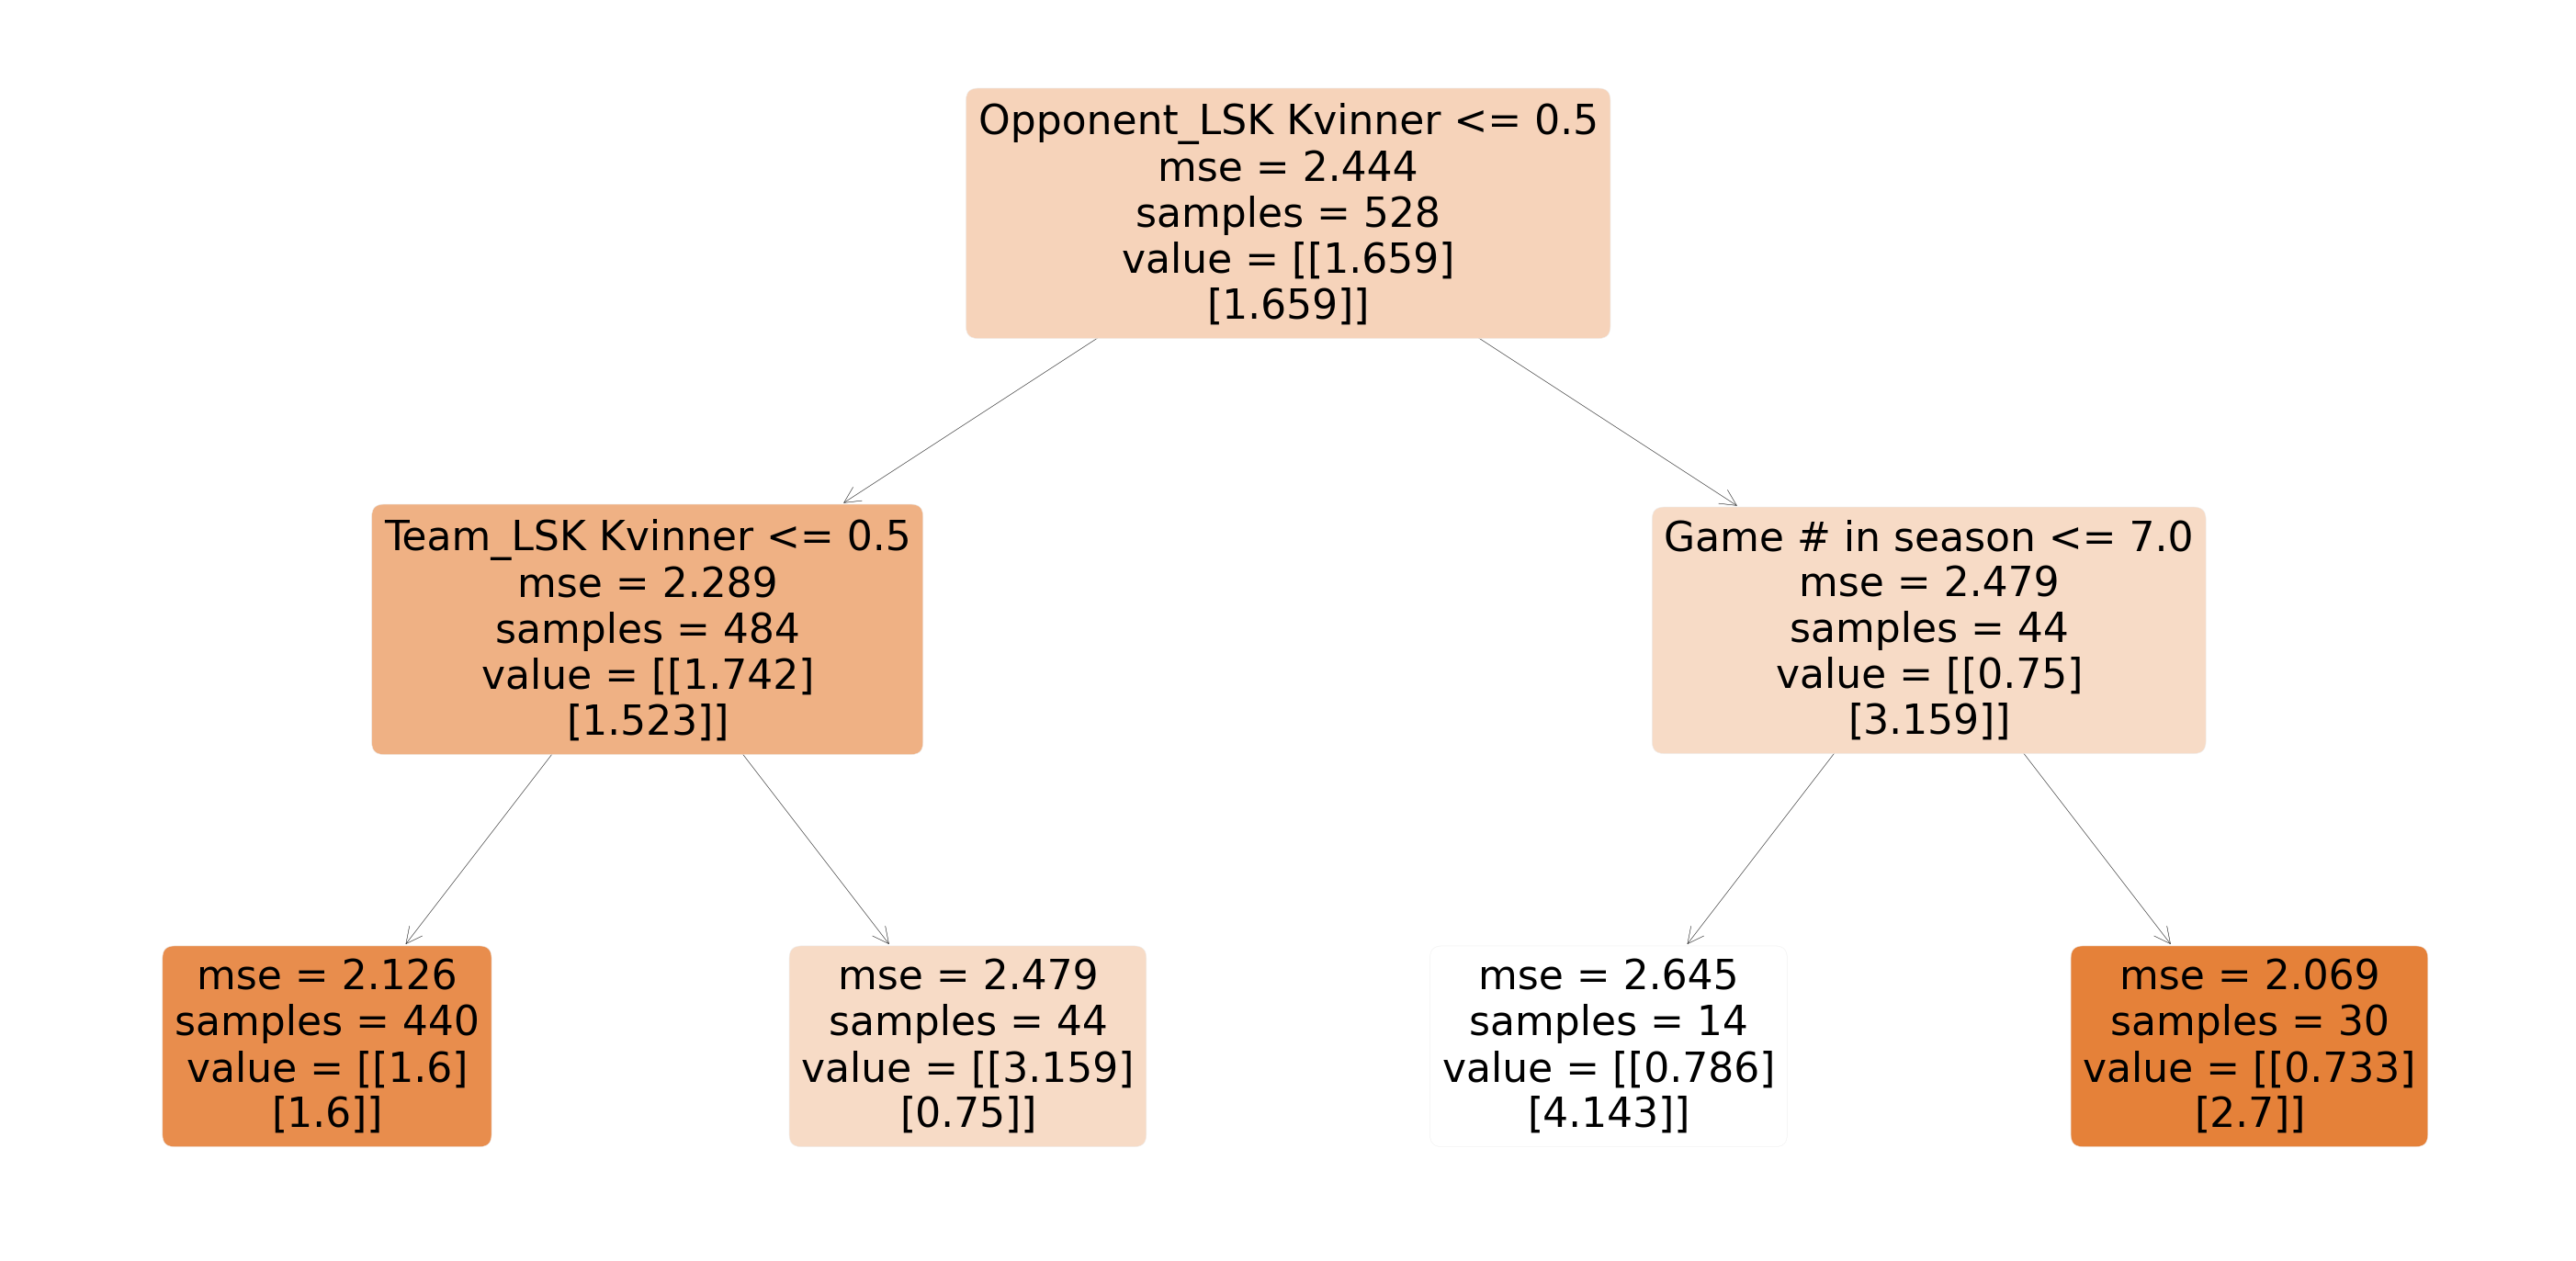

In [9]:
# Instanciating a simple decision tree model (for visualization purposes only)
dtree_model = DecisionTreeRegressor(max_depth=2, min_samples_split=20, min_samples_leaf=10, random_state=random_state)

# Training the model. Decision trees do not require scaled data
dtree_model.fit(X_train, y_train)

# Visualize the simple decision tree
fig = plt.figure(figsize=(50, 25))
tree_plot = plot_tree(dtree_model, feature_names=X_train.columns, 
                      class_names=y_train.columns, filled=True, rounded=True)

The plot clearly shows that the most important features are about whether the team is or is playing against *LSK Kvinner*. It is also interesting to see that the engineered feature *Game # in season* is on the second level, which might indicate that my hypothesis that I could capture information about long-term effects was correct. Teams that injure their players or get a lot of cards will likely play worse in the later stages of the season, thus making it easier for the models to predict for these teams. 

### <a id="pca-effect"></a>1.6) Analyzing the effect of Principal Component Analysis on training data

Text(0, 0.5, 'Explained variance')

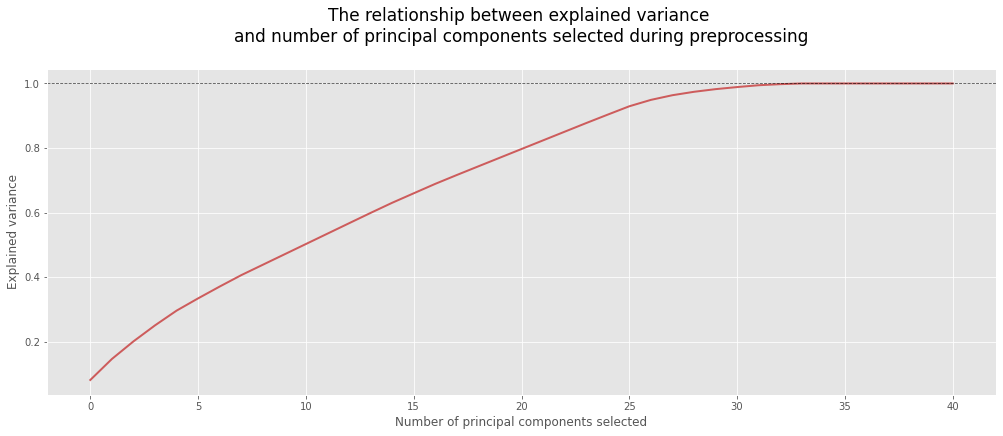

In [10]:
# PCA only works well with normalized data with zero mean and unit variance.
# I therefore apply RobustScaler on a copy of the training data
scaler = RobustScaler()
X_train_copy = X_train.copy()
X_train_copy_scaled = scaler.fit_transform(X_train_copy)
scaler = StandardScaler()
X_train_copy_scaled = scaler.fit_transform(X_train_copy_scaled)

pca = PCA()
pca.fit(X_train_copy_scaled)
p_components = pca.transform(X_train_copy_scaled)

# Visualising how much of the explained variation is captured as the number of selected components grows
plt.figure(figsize=(17,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='indianred', linewidth=2)
plt.axhline(1.0, ls='--', color='black', alpha=0.7, linewidth=0.8)
plt.title('The relationship between explained variance \nand number of principal components selected during preprocessing\n ', size=17)
plt.xlabel('Number of principal components selected')
plt.ylabel('Explained variance')

In [11]:
# Calculating the nth component which explains 100% of the variance in the data
cumsum = np.cumsum(pca.explained_variance_ratio_)
indeces = range(0, len(cumsum)-1)
nth_component_var_lt_one = ([(variance, index) for variance, index in zip(cumsum, indeces) if round(variance, 15) < 1.0][-1:][0])
print(f"Total number of principal components: {len(cumsum)}")
print(f"The {nth_component_var_lt_one[1] + 1}rd component explains 100% of the variance.")

Total number of principal components: 41
The 33rd component explains 100% of the variance.


Using 33 out of 40 principal components explains 100% of the variance in the training data. I will therefore add PCA to the model pipelines with the aim of reducing the model complexity and reducing the time required for each model to train.

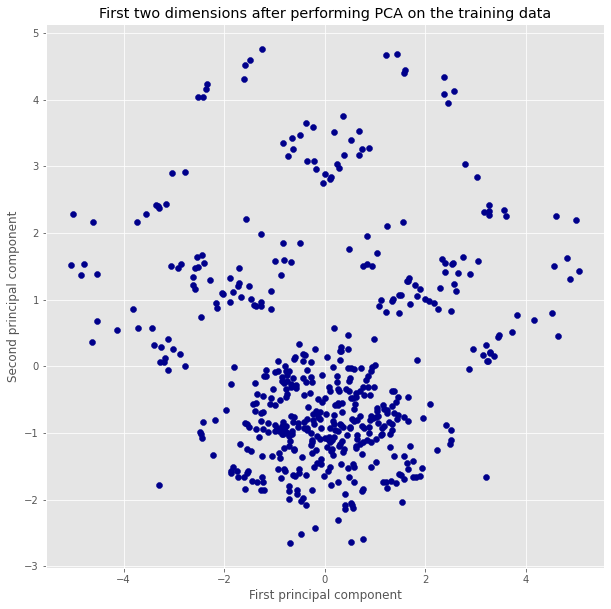

In [12]:
# Visualising the data with the 2 first principal components
plt.figure(figsize=(10,10))
plt.scatter(p_components[:, 0], p_components[:, 1], color='darkblue')
plt.title("First two dimensions after performing PCA on the training data")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

The plot shows that PCA is successful in grouping related samples together, thus I should be able to maintain the variance in the data with fewer dimensions. Interestingly, the plot also looks a lot like Yoda, but we can save the discussion on humans' ability to classify faces for later. 

<br>

[*back to top*](#top) 
## <a id="1st-iteration"></a>2) Modelling: First Iteration

This section will revolve around experimenting with a set of different models and evaluating them. I have split the modelling into two parts, one before and one after the second round of feature engineering. This is because I want to be able to accurately measure the effect of the new feature. 

I have chosen to experiment with 5 different families of machine learning algorithms. First, I will create a baseline model that predicts with the simplest metric I could think of. Then, I will try out a suite of linear models and tune the best one with a grid search. I will then go on to experiment with K Nearest Neighbours and Support Vector Machines, which may both have some significant advantages over the linear models. I will then move on to tree-based models, specifically decision trees, random forest and gradient boosting. Finally, I will increase the complexity of the models with neural networks by exploring the multi-layered perceptron. 

#### <a id="scaling"></a>2.1) Scaling the data

In [13]:
# Collective scaling for all models except baseline model
# First scaling with RobustScaler
robustscaler = RobustScaler()

# Fit on X_train, transform X_val and X_test
X_train_scaled = robustscaler.fit_transform(X_train)
X_val_scaled = robustscaler.transform(X_val)
X_test_scaled = robustscaler.transform(X_test)
X_trainval_scaled = robustscaler.transform(X_trainval)

# Fit on y_train, transform y_val and y_test
y_train_scaled = robustscaler.fit_transform(y_train)
y_val_scaled = robustscaler.transform(y_val)
y_test_scaled = robustscaler.transform(y_val)
y_trainval_scaled = robustscaler.fit_transform(y_trainval)

# Rescaling with StandardScaler
standardscaler = StandardScaler()

# Fit on X_train, transform X_val and X_test
X_train_scaled = standardscaler.fit_transform(X_train_scaled)
X_val_scaled = standardscaler.transform(X_val_scaled)
X_test_scaled = standardscaler.transform(X_test_scaled)
X_trainval_scaled = standardscaler.transform(X_trainval_scaled)

# Fit on y_train, transform y_val and y_test
y_train_scaled = standardscaler.fit_transform(y_train_scaled)
y_val_scaled = standardscaler.transform(y_val_scaled)
y_test_scaled = standardscaler.transform(y_test_scaled)
y_trainval_scaled = standardscaler.fit_transform(y_trainval_scaled)

#### 2.2)  <a id="pca"></a> Calculating the principal components

In [14]:
# Calculate the 33 principal components for independent variables (X)
pca = PCA(n_components=33)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_val_scaled = pca.transform(X_val_scaled)
X_test_scaled = pca.transform(X_test_scaled)
X_trainval_scaled = pca.fit_transform(X_trainval_scaled)

### <a id="baseline"></a>2.1) Baseline model
I want to establish a baseline RMSE which I can use to evaluate the success of the project. I don't want to use machine learning, because I would rather use a basic, intuitive estimate that mocks the way humans would try to guess at an answer to how many goals each team is going to score (with the assumption that the human doesn't know that much about soccer). The baseline "model" will therefore simply predict the average number of goals in the training data for both teams.

In [15]:
# Baseline model: Predict average nr. of goals for both teams with unscaled data
avg_nr_goals = y_train["y1: Team Score"].mean()
predictions = [ceil(avg_nr_goals) for i in range(len(X_val))]
squared_errors = np.array([[(prediction - int(true[0]))**2, 
           (prediction - int(true[1]))**2] for prediction, true in zip(predictions, y_val.values)])

print('RMSE for baseline predictions\n', 
      "Team Score (y1): ", sqrt(np.mean(squared_errors[:, 0])), 
      "\nOpponent Score (y2): ", sqrt(np.mean(squared_errors[:, 1])))

RMSE for baseline predictions
 Team Score (y1):  1.4937681492059234 
Opponent Score (y2):  1.4812257933030564


The baseline model has a pretty decent RMSE of about 1.5. It might prove quite difficult to beat!

### <a id="linear_regression"></a>2.2) Linear Regression models

Since most of the linear regression algorithms from Scikit-Learn don't properly support multioutput regression, I will use the RegressorChain estimator to chain regressors together. Instead of building multiple independent regressors and predicting on the target variable seperately (which can be achieved with MultiOutputRegressor), RegressorChain assumes that the predictor variables are dependent on each other. This is true in the case of predicting soccer scores for a home team and an opposing teams. When using RegressorChain, the first regressor is fitted on the input features and predicts on the first target feature. Then, a second regressor is fitted on the input feature **and** the predicted target feature from the first regressor. The second regressor then predicts for the second target feature. 

In [16]:
# Linear Regression for each dependent/target variable 
linreg_model = RegressorChain(base_estimator=LinearRegression())
lasso_model = RegressorChain(base_estimator=Lasso())
ridge_model = RegressorChain(base_estimator=Ridge())
elasticnet_model = RegressorChain(base_estimator=ElasticNet(max_iter=5000))

# Linear Regression with the Partial Least Squares (PLS) multioutput regression method
plsreg_model = PLSRegression()

models = [linreg_model, lasso_model, ridge_model, elasticnet_model, plsreg_model]

for model, modelname in zip(models, ["Linear Regression", "Lasso", "Ridge", "ElasticNet", "Partial Least Squares"]):
    # Training the model 
    model.fit(X_train_scaled, y_train_scaled)
    
    print(f"""--------------------------------------------------------------------------
    Predicting with {modelname}:""")
    # Prediction on training data
    train_predict = model.predict(X_train_scaled)
    r2_trainpred = r2_score(y_train_scaled, train_predict)
    print(f'R2 for predictions made on training data:', r2_trainpred)

    # Prediction on validation data
    val_predict = model.predict(X_val_scaled)
    r2_valpred = r2_score(y_val_scaled, val_predict)
    print(f'R2 for predictions made on validation data:', r2_valpred)

    # Calculating the RMSE for predictions made on validation data
    val_predict_minmax_unscaled = standardscaler.inverse_transform(val_predict)
    val_predict_unscaled = robustscaler.inverse_transform(val_predict_minmax_unscaled)
    print(f'RMSE for {modelname}: ', sqrt(mean_squared_error(val_predict_unscaled, y_val)))

--------------------------------------------------------------------------
    Predicting with Linear Regression:
R2 for predictions made on training data: 0.3474297709947187
R2 for predictions made on validation data: -0.29555532638890947
RMSE for Linear Regression:  1.553436309686338
--------------------------------------------------------------------------
    Predicting with Lasso:
R2 for predictions made on training data: 0.0
R2 for predictions made on validation data: -0.02728140430839643
RMSE for Lasso:  1.3916040875175486
--------------------------------------------------------------------------
    Predicting with Ridge:
R2 for predictions made on training data: 0.3474269909941079
R2 for predictions made on validation data: -0.29224308299146695
RMSE for Ridge:  1.5515021992590197
--------------------------------------------------------------------------
    Predicting with ElasticNet:
R2 for predictions made on training data: 0.003011325242417262
R2 for predictions made on val

ElasticNet and Lasso perform very well here, with ElasticNet slightly outperform Lasso with the default parameters. 
I hope that parameter tuning might further improve the accuracy of the linear models. I will continue with ElasticNet, because while Lasso only uses L1 regression, ElasticNet uses both L1 and L2 regression, which means that the hypethesis space of all models trained with ElasticNet includes the hypothesis space of all possible Lasso models as well. In other words, an ElasticNet model can be at least as good as the best possible Lasso model (I can just set the parameter "l1_ratio" to 1), but also better since it can be fine-tuned with more parameters. I also think that ElasticNet will outperform a model using only L1 regression because the correlation analysis indicated that many of the features were important for predicting the target variable. Lasso will try to reduce as many weights as possible to 0, rendering many features useless (though this could also be used for further dimensionality reduction).

To determine the optimal ElasticNet model, I will use a grid search *without* cross validation to evaluate models with different parameters for L1 and L2 regularization. I don't want to use cross validation because I don't want to shuffle the data, which is something that can't be done with Sklearn's `gridsearchcv` method. I want to be able to use data from 2017 and 2018 to predict the scores of games played in 2019, because I will be doing something similar when predicting on the 2020 data. I also don't want to have to shuffle the 2020 data, because it will be hard to reattach the games' `ID` values after training the final model at the end of the project. I have therefore decided to code my own version of grid search, without shuffling the data. I will be relying heavily on [Sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for `gridsearchcv` to accomplish this.

In [17]:
# Creating a function for running a grid search over a model's parameters without cross validation or shuffling
def grid_search_no_cv(model, parameter_grid, X_train, X_val, y_train, y_val, 
                      y_train_true=y_train, y_val_true=y_val, chain_regressor=True, 
                      data_is_scaled=True, sample_weights=None):
    """
    Function for running a grid search over an estimator's parameters without performing
    cross validation or random shuffling/splitting of the data. 
    Any necessary data preprocessing must be done in advance.
    
    :param model: A Scikit-learn estimator instance
    :param parameters: A sklearn.model_selection.ParameterGrid object with the parameters for 
                       tuning the model during grid search
    :param X_train: Training data with the independent variables for fitting the model. 
    :param X_val: The validation data with the independent variables required for predictions
    :param y_train: Training data with the dependent variables for fitting the model.       
    :param y_val: The validation data required to evaluating the model's predictions (r2, RMSE)
    :return: The best model found during grid search, and a Pandas DataFrame with the results
    """

    # Using defaultdict to easily store the results as {key: [values]}
    tuning_results = defaultdict(list)
    
    # For storing the best model
    best_model = None
    
    # Performing the grid search over all param combinations
    for params in parameter_grid:
        # Creating a new estimator object with default params and without any regressor chaining
        current_model = model
        # Setting the estimators' parameters
        current_model = current_model.set_params(**params)
        
        if chain_regressor==True:
            # Creating a RegressorChain instance with the model to enable multioutput regression
            current_model = RegressorChain(base_estimator=current_model)

        # Fitting the model on the training data
        if sample_weights is None: 
            current_model.fit(X_train, y_train)  # fitting without sample weights
        else:
            current_model.fit(X_train, y_train, sample_weight=sample_weights)  # fitting with sample weights
        
        # Storing the current model's parameters in the tuning results dict
        for param in params.keys():
            tuning_results[param].append(params[param])
        
        
        # Prediction on training data
        train_predict = current_model.predict(X_train)  # predicting on train
        tuning_results["r2_train"].append(r2_score(y_train, train_predict))  # calculating r2 and add to results
        if data_is_scaled:
            # unscaling predictions and rounding to nearest int
            train_predict_minmax_unscaled = standardscaler.inverse_transform(train_predict)
            train_predict_unscaled = np.rint(robustscaler.inverse_transform(train_predict_minmax_unscaled))  
            tuning_results["RMSE_train"].append(sqrt(mean_squared_error(train_predict_unscaled, y_train_true)))  # calculating RMSE
        else:
            train_predict= np.rint(train_predict)  # Rounding predictions to nearest int
            tuning_results["RMSE_train"].append(sqrt(mean_squared_error(train_predict, y_train_true)))
        
        # Prediction on validation data
        val_predict = current_model.predict(X_val)  # predicting on val
        tuning_results["r2_val"].append(r2_score(y_val, val_predict))  # calculating r2
        if data_is_scaled:
            # unscaling predictions and rounding to nearest int
            val_predict_minmax_unscaled = standardscaler.inverse_transform(val_predict)
            val_predict_unscaled = np.rint(robustscaler.inverse_transform(val_predict_minmax_unscaled)) 
            rmse_val = sqrt(mean_squared_error(val_predict_unscaled, y_val_true))  # calculating RMSE
        else:
            val_predict = np.rint(val_predict)  # rounding predictions to nearest int
            rmse_val = sqrt(mean_squared_error(val_predict, y_val_true))  # calculating RMSE
        
        
        # If results are empty, or if the RMSE for predicting on validation data is better than any previous model
        if (best_model is None) or (rmse_val < min(tuning_results["RMSE_val"])):
            # the current model is the best model
            best_model = copy.deepcopy(current_model)

        # Add RMSE for predicting on validation data to results
        tuning_results["RMSE_val"].append(rmse_val)  
        
    # Converting results to a Pandas DataFrame
    tuning_results = pd.DataFrame(tuning_results)

    
    return tuning_results, best_model

In [18]:
# Instanciating the ElasticNet estimator with params I don't want to tune
elasticnet = ElasticNet(max_iter=10000)

# Defining the parameters I want to tune
parameters = {
'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 3],
'l1_ratio': [0.00001, 0.0001, 0.001, 0.05, 0.1, 0.2, 0.4, 0.5, 1]
}

# Calculating all unique combinations of the parameters
grid = ParameterGrid(parameters)

# Run the grid search without cross validation
elasticnet_tuning_results, elasticnet_best_model = grid_search_no_cv(elasticnet, grid, X_train_scaled, 
                                                                     X_val_scaled, y_train_scaled, y_val_scaled, 
                                                                     y_train_true=y_train, y_val_true=y_val)
# Display the results
display(elasticnet_tuning_results.T)
print(f"Tuned model: {elasticnet_best_model}")
print(f"RMSE of tuned model: {min(elasticnet_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
alpha,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
l1_ratio,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000
r2_train,0.347356,0.347356,0.347355,0.347316,0.347258,0.347100,0.346628,0.346305,0.343953,0.345907,0.345906,0.345894,0.345082,0.343946,0.340815,0.332187,0.326783,0.286610,0.342498,0.342494,0.342454,0.339702,0.335870,0.326056,0.298104,0.279795,0.197659,0.304123,0.304080,0.303642,0.274690,0.237298,0.168686,0.097761,0.076470,0.003507,0.278397,0.278323,0.277575,0.229098,0.175908,0.111355,0.046892,0.029998,0.000000,0.263489,0.263396,0.262458,0.202305,0.145456,0.085687,0.028497,0.003011,0.000000,0.250125,0.250014,0.248902,0.178831,0.124216,0.067815,0.008148,0.000000,0.000000,0.232511,0.232378,0.231029,0.150885,0.099247,0.043744,0.000000,0.000000,0.000000,0.172592,0.172376,0.170200,0.075021,0.033678,0.000000,0.000000,0.000000,0.000000
RMSE_train,1.285481,1.285481,1.285481,1.283638,1.283269,1.281054,1.278464,1.277352,1.280314,1.281793,1.281793,1.281793,1.282531,1.282531,1.288057,1.300131,1.311733,1.346643,1.284007,1.284007,1.284007,1.285481,1.294657,1.304131,1.333215,1.354706,1.431187,1.329659,1.329659,1.332504,1.352607,1.388876,1.468418,1.519445,1.529693,1.600189,1.346643,1.346643,1.346994,1.403459,1.463249,1.514451,1.560946,1.576641,1.600189,1.360634,1.360634,1.359242,1.439105,1.484133,1.528455,1.578141,1.600189,1.600189,1.369652,1.369652,1.371725,1.453509,1.498105,1.542639,1.600189,1.600189,1.600189,1.399405,1.399066,1.399405,1.477418,1.516013,1.562462,1.600189,1.600189,1.600189,1.443376,1.445343,1.451554,1.529384,1.574537,1.600189,1.600189,1.600189,1.600189
r2_val,-0.278732,-0.278728,-0.278696,-0.276930,-0.275128,-0.271069,-0.262031,-0.257115,-0.234145,-0.224869,-0.224855,-0.224714,-0.216445,-0.206585,-0.187167,-0.151429,-0.133172,-0.047454,-0.178038,-0.178015,-0.177777,-0.162875,-0.146711,-0.117648,-0.059710,-0.034109,0.013763,-0.049067,-0.049012,-0.048465,-0.020844,0.005865,0.027363,0.038243,0.033609,-0.023331,-0.020956,-0.020898,-0.020325,0.008494,0.024512,0.037050,0.020835,0.004889,-0.027281,-0.010096,-0.010037,-0.009458,0.019551,0.031067,0.034238,0.003378,-0.023887,-0.027281,-0.002471,-0.002414,-0.001807,0.024144,0.033738,0.028409,-0.018184,-0.027281,-0.027281,0.005269,0.005324,0.005945,0.027481,0.033121,0.017926,-0.027281,-0.027281,-0.027281,0.017597,0.017632,0.018079,0.024005,0.008453,-0.027281,-0.027281,-0.027281,-0.027281
RMSE_val,1.550156,1.550156

Tuned model: RegressorChain(base_estimator=ElasticNet(alpha=1.5, l1_ratio=0.1,
                                         max_iter=10000))
RMSE of tuned model: 1.3341104700393656


The tuned ElasticSearch model performs very well, with a RMSE of 1.33. I believe this is because I am able to carefully adjust multiple regularization parameters to prevent over- and underfitting, thus maximising the accuracy on the validation set. However, I might be overfitting the model for the validation set, so it will be interesting to see what the accuracy will be if I use this model to predict on the test data. If it is very bad, I might have to start over!

Next, I want to visualise the grid search results with a heatmap.

In [19]:
# Function for plotting 2D heatmaps of quadratic shape
# A variant of the mglearn package's plot_heatmap function from: https://github.com/amueller/introduction_to_ml_with_python
def plot_heatmap(values, xlabel, ylabel, xticklabels, yticklabels):
    ax = plt.gca()
    heatmap = ax.pcolor(values, cmap="RdBu")
    heatmap.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for path, color, value in zip(heatmap.get_paths(), 
                                  heatmap.get_facecolors(),
                                  heatmap.get_array()):
        x, y = path.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, "%0.3f" % value, color=c, 
                ha="center", va="center")
    
    return heatmap


# Custom function for setting the size of a plt.gca() axis object
# Sourced from ImportanceOfBeingErnest's StackOverFlow answer here: 
# https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Heatmap is coloured such that: good scores --> dark red, mediocre scores --> white, bad scores --> dark blue


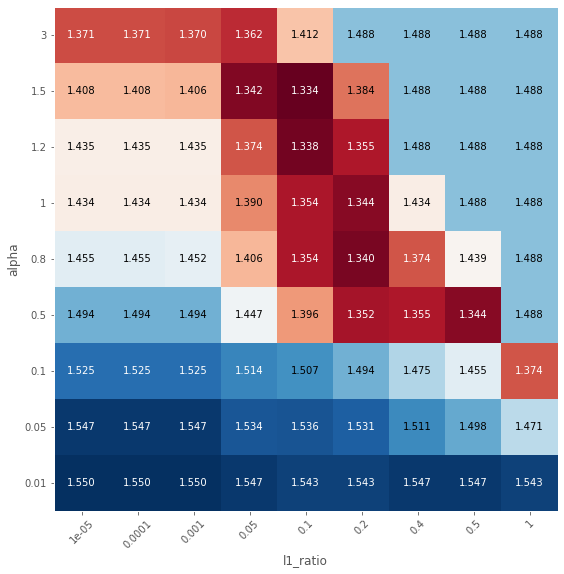

In [20]:
# Plot a 9x9 heatmap with the mean test scores (RMSE) during parameter tuning
scores = np.array(elasticnet_tuning_results["RMSE_val"]).reshape(9, 9)
set_size(7, 7)
print("Heatmap is coloured such that: good scores --> dark red, mediocre scores --> white, bad scores --> dark blue")
heatmap = plot_heatmap(scores, 
                       ylabel='alpha', yticklabels=parameters['alpha'], 
        xlabel="l1_ratio", xticklabels=parameters['l1_ratio'])

The heatmap above visualizes the accuracies (RMSE) obtained during parameter tuning. The dark red tiles have the best (lowest) scores, while the dark blue tiles have the worst scores. We can see that we found the most optimal parameters towards the centre of the heatmap. This means that the most optimal parameters are likely within the range of the search space of the grid search. It is possible that I can find more optimal parameters by "zooming" in on the heatmap, i.e. performing a new grid search with new parameters closer to alpha==1 and l1_ratio==0.8. However, I doubt that performing a new grid search will result in any significant improvement in accuracy. 

(528, 33)
NB! There may be some coefficients that are approaching, but not equal to zero, which are shown as zero due to rounding.


Text(0.5, 0, 'Coefficient')

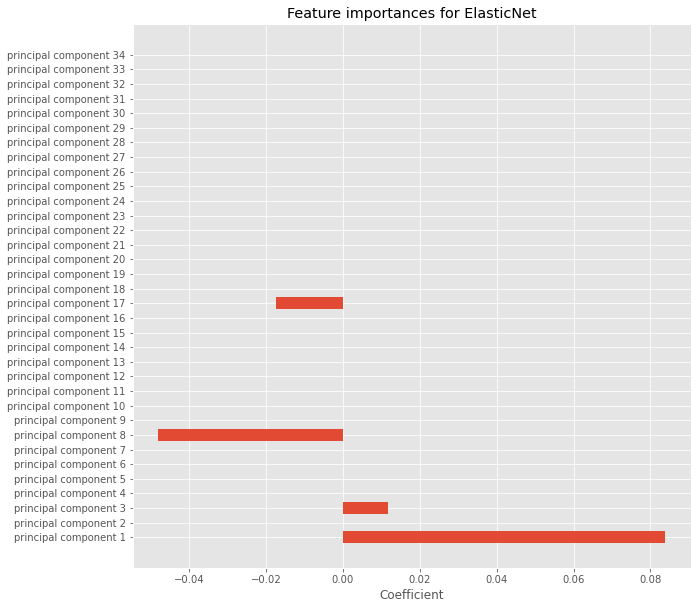

In [21]:
# Plot the importance of each feature (coefficients/weights)
fig, ax = plt.subplots(figsize=(10, 10))
print(X_train_scaled.shape)
coef = elasticnet_best_model.estimators_[1].coef_
plt.barh([f"principal component {i}" for i in range(1,35)], coef)
print("NB! There may be some coefficients that are approaching, but not equal to zero, which are shown as zero due to rounding.")
ax.set_title("Feature importances for ElasticNet")
ax.set_xlabel("Coefficient")

The ElasticNet model reduced most of the features to 0, which is quite unexpected. I hope to see that more of the features will be used when using more complex machine learning algorithms, because I don't think that ElasticNet is utilising the full potential of the data. There might be many non-linear relationships that ElasticNet isn't picking up on. 

When comparing the accuracy of the best model with the accuracy of the baseline model, I see that the ElasticNet model greatly outperforms the baseline. I can additionally see that the ElasticNet models achieve a much better accuracy on training data than on validation data, even though the accuracy on training data is still bad (RMSE of 1.28 at best). In conclusion, the linear regression models might be unable to capture the variation in the training data. I will therefore move on from linear regression algorithms and try different approaches. 

### <a id="knn"></a>2.3) K Nearest Neighbours


KNN is a simple machine learning algorithm that predicts the mean of the most similar observations in the training data (similarity is measured by Euclidean distance). KNN can provide a very simple and intuitive prediction, while being able to pick up on non-linear relationships in the data. However, this will only work for a low number of neighbours (K), becaue a model with high K simply predicts the mean (expected) value - which is identical to the baseline model. 

In [22]:
# Instanciating the model with the parameters I don't want to tune
knn = KNeighborsRegressor(n_jobs=-1, weights='distance')

# Parameters to be tuned
parameters = {
'n_neighbors': [i for i in range(1, 21)],
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for KNN, with regressor chaining
knn_tuning_results, best_knn_model = grid_search_no_cv(knn, grid, X_train_scaled, X_val_scaled, y_train_scaled, 
                                                       y_val_scaled, y_train_true=y_train, y_val_true=y_val,
                                                       chain_regressor=True, data_is_scaled=True)
# Display the results from the grid search
display(knn_tuning_results.T)
print(f"Tuned model: {best_knn_model}")
print(f"RMSE of tuned model: {min(knn_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
n_neighbors,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
r2_train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
RMSE_train,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r2_val,-1.352275,-0.739895,-0.543982,-0.434568,-0.316193,-0.256963,-0.224802,-0.189741,-0.163001,-0.174196,-0.165825,-0.155156,-0.147648,-0.131762,-0.123991,-0.117913,-0.111499,-0.104905,-0.104123,-0.108775
RMSE_val,2.113390,1.818233,1.721246,1.680663,1.584675,1.553763,1.514852,1.524673,1.523449,1.541709,1.523449,1.497510,1.493768,1.508681,1.491268,1.497510,1.492519,1.479966,1.476179,1.474915


Tuned model: RegressorChain(base_estimator=KNeighborsRegressor(n_jobs=-1, n_neighbors=20,
                                                  weights='distance'))
RMSE of tuned model: 1.4749146193350848


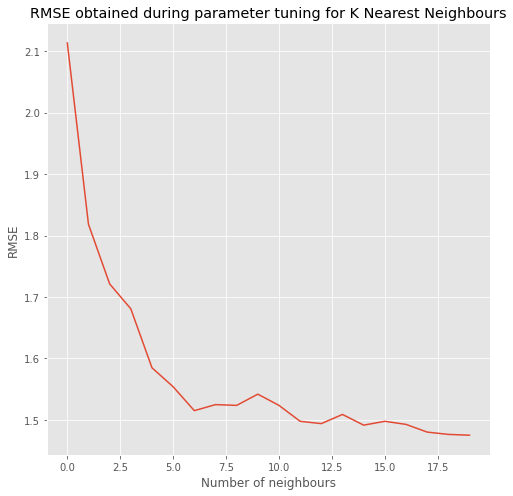

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(knn_tuning_results["RMSE_val"])
ax.set_title("RMSE obtained during parameter tuning for K Nearest Neighbours")
ax.set_xlabel("Number of neighbours")
ax.set_ylabel("RMSE")
fig.tight_layout()
plt.show()

The best KNN model performed with an RMSE of 1.48, which is identical to the baseline. KNN is therefore unsuccessful.

### <a id="svm"></a>2.4) Support Vector Regression


SVR with the RBF kernel might be able to detect non-linear relationships in the data. I expect that SVR will perform better than both the linear models and the neural network, because it is a more complex algorithm that works well with a low amount of samples.

In [24]:
# Instanciating the model with the parameters I don't want to tune
svr = SVR(gamma='auto', kernel="rbf", max_iter=-1)

# Grid search over various parameter settings
parameters = {
'C': [0.001, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 2, 10, 100], 
'epsilon': [0.0001, 0.001, 0.0015, 0.005, 0.01, 0.2, 0.3, 0.5, 1, 1.5]
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for SVR, with regressor chaining
svr_tuning_results, best_svr_model = grid_search_no_cv(svr, grid, X_train_scaled, X_val_scaled, y_train_scaled, 
                                                       y_val_scaled, y_train_true=y_train, y_val_true=y_val,
                                                       chain_regressor=True, data_is_scaled=True)
# Display the results from the grid search
display(svr_tuning_results.T)
print(f"Tuned model: {best_svr_model}")
print(f"RMSE of tuned model: {min(svr_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
C,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
epsilon,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000,0.000100,0.001000,0.001500,0.005000,0.010000,0.200000,0.300000,0.500000,1.000000,1.500000
r2_train,-0.171368,-0.170773,-0.170405,-0.167494,-0.163335,-0.044025,-0.010205,-0.074952,-0.001839,-0.192030,0.415456,0.415470,0.415485,0.415540,0.415631,0.412337,0.402746,0.387287,0.275476,-0.117173,0.466936,0.466969,0.466958,0.467010,0.467029,0.460096,0.452796,0.432908,0.311456,-0.103972,0.506281,0.506268,0.506270,0.506257,0.506197,0.501043,0.490551,0.471090,0.336119,-0.095518,0.538602,0.538624,0.538635,0.538660,0.538705,0.532564,0.522405,0.502302,0.352865,-0.088573,0.565262,0.565261,0.565266,0.565291,0.565317,0.559498,0.550909,0.529098,0.365447,-0.082994,0.628104,0.628169,0.628197,0.628447,0.628775,0.628533,0.621968,0.591623,0.393183,-0.074803,0.759838,0.759968,0.760041,0.760518,0.761171,0.766769,0.755580,0.701906,0.441739,-0.059664,0.988959,0.988994,0.989013,0.989130,0.989258,0.958764,0.919858,0.811024,0.467225,-0.053703,1.000000,0.999999,0.999997,0.999972,0.999891,0.962415,0.921123,0.811024,0.467225,-0.053703
RMSE_train,1.696699,1.696699,1.696699,1.696699,1.696699,1.696699,1.696699,1.696699,1.600189,1.600189,1.243163,1.243163,1.243163,1.242782,1.244686,1.218544,1.247346,1.292827,1.425884,1.491453,1.176232,1.176232,1.176232,1.176232,1.177842,1.164907,1.184656,1.254537,1.401771,1.485728,1.131923,1.131505,1.131923,1.131086,1.133177,1.117610,1.151004,1.202507,1.382041,1.483495,1.093195,1.093628,1.091461,1.090159,1.090159,1.088855,1.126892,1.183856,1.360634,1.473568,1.077929,1.077929,1.077929,1.076611,1.076611,1.073969,1.099673,1.169369,1.350505,1.470351,0.989529,0.989529,0.994302,0.994302,0.993826,0.989529,1.030317,1.115490,1.334635,1.460334,0.804227,0.804227,0.801277,0.797130,0.794751,0.750000,0.846674,0.988571,1.294291,1.447634,0.184637,0.184637,0.184637,0.184637,0.184637,0.144338,0.600663,0.870388,1.277352,1.439434,0.000000,0.000000,0.000000,0.000000,0.000000,0.068810,0.601450,0.870388,1.277352,1.439434
r2_val,-0.106529,-0.105964,-0.

Tuned model: RegressorChain(base_estimator=SVR(C=0.3, epsilon=0.5, gamma='auto'))
RMSE of tuned model: 1.4142135623730951


Heatmap is coloured such that: good scores --> dark red, mediocre scores --> white, bad scores --> dark blue


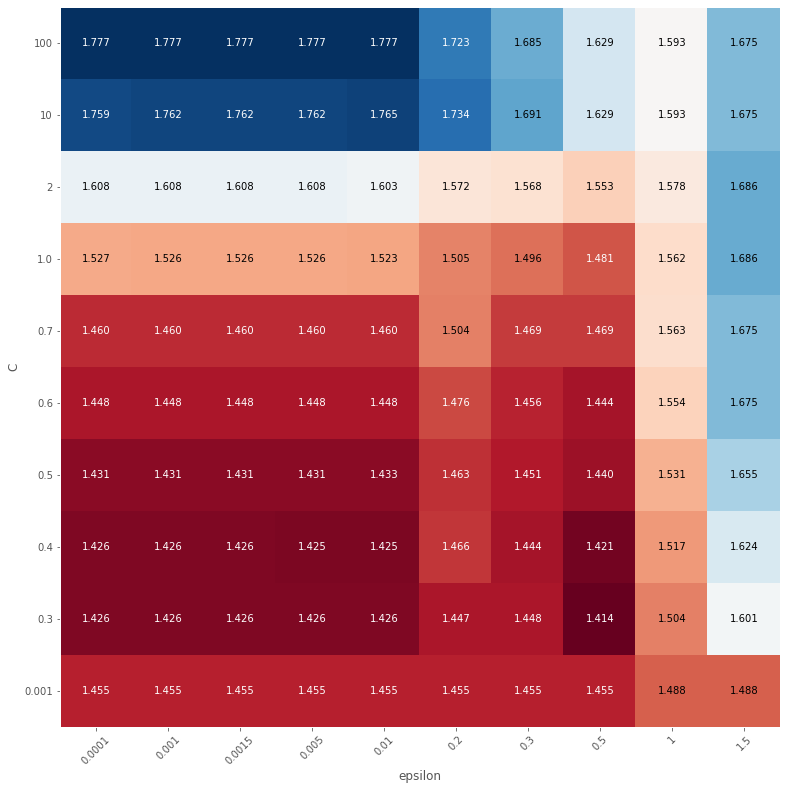

In [25]:
# Plotting a 10x10 heatmap with the mean test scores (RMSE) during parameter tuning with RBF kernel
scores = np.array(svr_tuning_results["RMSE_val"]).reshape(10, 10)
set_size(10, 10)
print("Heatmap is coloured such that: good scores --> dark red, mediocre scores --> white, bad scores --> dark blue")
heatmap = plot_heatmap(scores, ylabel='C', yticklabels=parameters['C'], 
                       xlabel="epsilon", xticklabels=parameters['epsilon'])

The RMSE for the SVR model was disappointingly high. The heatmap of the results from grid search shows that tuning the model further is unlikely to substantially improve the accuracy, becuause the best results are homogenic across multiple different parameters (there is a lot of red). I will now continue to a completely different class of algorithms.

### <a id="decision_trees"></a>2.5) Decision Trees

I will start by training a more complex decision tree than the one I made previously. This will give me an indication of whether the tree-based models are worth investigating. An additional benefit of the decision tree approach is that these algorithms are easily explainable and interpretable. It is relatively easy to visualize a single decision tree through the plot_tree()-method, which allows for simple and effective communication of results. 

#### 2.5.1) Decision Tree Regressor

In [26]:
# Instanciating the Decision Tree estimator with params I don't want to tune
dtree = DecisionTreeRegressor(random_state=random_state)

# Defining the parameters I want to tune
parameters = {
'max_depth': [5, 6, 7, 8, 9, 10],
'min_samples_split': [8, 9, 10, 11, 12],
'min_samples_leaf': [2, 3, 4, 5, 6]
}

# Calculating all unique combinations of the parameters
grid = ParameterGrid(parameters)

# Run the grid search without cross validation. No regressor chaining or scaling is needed with Decision Trees
dtree_tuning_results, dtree_best_model = grid_search_no_cv(dtree, grid, X_train, X_val, y_train, 
                                                           y_val, chain_regressor=False, 
                                                           data_is_scaled=False)
# Display the results
display(dtree_tuning_results.T)
print(f"Tuned model: {dtree_best_model}")
print(f"RMSE of tuned model: {min(dtree_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
max_depth,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
min_samples_leaf,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000
min_samples_split,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,10.000000,11.000000,12.000000,8.000000,9.000000,1

Tuned model: DecisionTreeRegressor(max_depth=6, min_samples_leaf=6, min_samples_split=8,
                      random_state=42)
RMSE of tuned model: 1.4749146193350848


The RMSE of the best decision tree model isn't great, but since it is better than the baseline I will continue exploring these algorithms. Next up is the Random Forest, which I believe is going to perform very well due to its ability to simultaeneously predict multiple outputs.

#### 2.5.2) Random Forest Regressor

In [27]:
# Instanciating the model with the parameters I don't want to tune
rfr = RandomForestRegressor(n_estimators=1000, random_state=random_state)

# Defining the parameters I want to tune
parameters = {
'max_depth': [1, 2, 3, 4],
'min_samples_split': [2, 3, 4, 5],
'min_samples_leaf': [1, 2, 3, 4],
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for Random Forest Regressor
rfr_tuning_results, best_rfr_model = grid_search_no_cv(rfr, grid, X_train, X_val, y_train, y_val, 
                                                       chain_regressor=False, data_is_scaled=False)
# Display the results from the grid search
display(rfr_tuning_results.T)
print(f"Tuned model: {best_rfr_model}")
print(f"RMSE of tuned model: {min(rfr_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
max_depth,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
min_samples_leaf,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000
min_samples_split,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000
r2_train,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.102168,0.177330,0.177330,0.177330,0.177330,0.177290,0.177290,0.177290,0.177290,0.176981,0.176981,0.176981,0.176981,0.176565,0.176565,0.176565,0.176565,0.248130,0.247850,0.247168,0.246356,0.246543,0.246543,0.246543,0.245863,0.244423,0.244423,0.244423,0.244423,0.241598,0.241598,0.241598,0.241598,0.315679,0.314611,0.312897,0.310949,0.310859,0.310859,0.310859,0.308972,0.304054,0.304054,0.304054,0.304054,0.296558,0.296558,0.296558,0.296558
RMSE_train,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.539567,1.471960,1.471960,1.471960,1.471960,1.471960,1.471960,1.471960,1.471960,1.477739,1.477739,1.477739,1.477739,1.477739,1.477739,1.477739,1.477739,1.387853,1.387853,1.387853,1.387853,1.390920,1.390920,1.390920,1.390920,1.393301,1.393301,1.393301,1.393301,1.398728,1.398728,1.398728,1.398728,1.315338,1.314978,1.315698,1.317855,1.322160,1.322160,1.322160,1.322160,1.327877,1.327877,1.327877,1.327877,1.333925,1.333925,1.333925,1.333925
r2_val,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.022289,0.034761,0.034761,0.034761,0.034761,0.034817,0.034817,0.034817,0.034817,0.034686,0.034686,0.034686,0.034686,0.035231,0.035231,0.035231,0.035231,0.031240,0.031142,0.031106,0.030877,0.031961,0.031961,0.031961,0.031689,0.030704,0.030704,0.030704,0.030704,0.031775,0.031775,0.031775,0.031775,0.021467,0.020536,0.020660,0.019897,0.023700,0.023700,0.023700,0.022885,0.020742,0.020742,0.020742,0.020742,0.023074,0.023074,0.023074,0.023074
RMSE_val,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1

Tuned model: RandomForestRegressor(max_depth=3, min_samples_leaf=2, n_estimators=1000,
                      random_state=42)
RMSE of tuned model: 1.3982932026570876


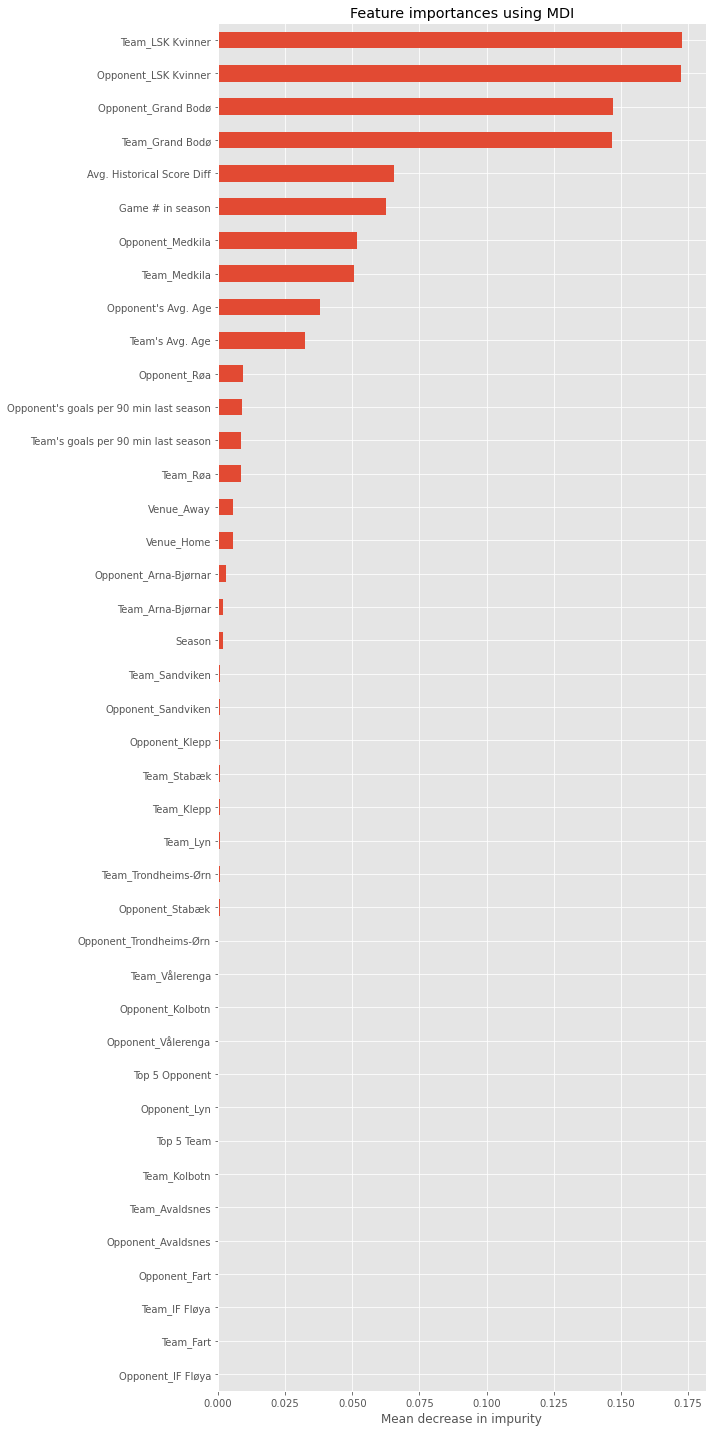

In [28]:
# Calculating feature importances with MDI (mean decrease in impurity)
feature_names = [str(feature) for feature in X_train.columns]
forest_importances = pd.Series(best_rfr_model.feature_importances_, index=feature_names).sort_values()

# Visualising feature importances as bar plot
fig, ax = plt.subplots(figsize=(10, 20))
forest_importances.plot.barh()
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

The RMSE of the random forest model is 1.39, which is very good but still not better than ElasticNet.

#### 2.5.3) Gradient Boosting Regressor

In [29]:
# Instanciating the model with the parameters I don't want to tune
grb = GradientBoostingRegressor(n_estimators=1000, random_state=random_state)

# Defining the parameters I want to tune
parameters = {
'max_depth': [3, 5, 8, 10, 12, 15],
'min_samples_split': [2, 4, 5, 6, 8, 10],
'min_samples_leaf': [1, 2, 5], 
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for Gradient Boosting Regressor, with regressor chaining
grb_tuning_results, best_grb_model = grid_search_no_cv(grb, grid, X_train, X_val, y_train, y_val, 
                                                       chain_regressor=True, data_is_scaled=False)
# Display the results from the grid search
display(grb_tuning_results.T)
print(f"Tuned model: {best_grb_model}")
print(f"RMSE of tuned model: {min(grb_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
max_depth,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
min_samples_leaf,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
min_samples_split,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.00000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000,2.000000,4.000000,5.000000,6.000000,8.000000,10.000000
r2_train,0.984347,0.983037,0.980431,0.978912,0.975920,0.974722,0.977612,0.977612,0.977047,0.976032,0.974583,0.972094,0.962612,0.962612,0.962612,0.962612,0.962612,0.962612,1.000000,0.999999,0.999999,0.999998,0.999993,0.999983,0.999998,0.999998,0.999997,0.999993,0.999978,0.999957,0.999875,0.999875,0.999875,0.999875,0.999875,0.999875,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

Tuned model: RegressorChain(base_estimator=GradientBoostingRegressor(max_depth=8,
                                                        min_samples_split=10,
                                                        n_estimators=1000,
                                                        random_state=42))
RMSE of tuned model: 1.4887638867354895


The Gradient Boosting model performed a lot worse than the random forest model. I will now proceed to use a neural network, which I am hoping will be able to capture both the variation and non-linear relationships of the data.

### <a id="mlp"></a>2.5) Multi-Layer Perceptron

In [30]:
# Instanciating the model with the parameters I don't want to tune
mlp = MLPRegressor(shuffle=False, random_state=random_state)

# Check regression for various parameter settings.
parameters = {
'hidden_layer_sizes': [(25, ), (50, ), (100, ), (25, 25), (50, 50)],
'alpha': [0.5, 1, 1.5, 2, 2.3, 2.5, 3, 5, 10],
'activation': ['logistic', 'tanh'], 
'solver': ['adam', 'sgd'],
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for MLP, with regressor chaining
mlp_tuning_results, best_mlp_model = grid_search_no_cv(mlp, grid, X_train_scaled, X_val_scaled, y_train_scaled, 
                                                       y_val_scaled, y_train_true=y_train, y_val_true=y_val,
                                                       chain_regressor=True, data_is_scaled=True)
# Display the results from the grid search
display(mlp_tuning_results.T)
print(f"Tuned model: {best_mlp_model}")
print(f"RMSE of tuned model: {min(mlp_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
activation,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,logistic,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh
alpha,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
hidden_layer_sizes,"(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100,)","(100,)","(25, 25)","(25, 25)","(50, 50)","(50, 50)","(25,)","(25,)","(50,)","(50,)","(100

Tuned model: RegressorChain(base_estimator=MLPRegressor(activation='logistic', alpha=5,
                                           hidden_layer_sizes=(50,),
                                           random_state=42, shuffle=False,
                                           solver='sgd'))
RMSE of tuned model: 1.3699874713448261


While the MLP model performs quite well, it is surprisingly unable to outperform the ElasticNet model. I am beginning to believe that there simply isn't enough data for the complex algorithms to work well, so a linear model may very well be the best approach. As a final attempt at improving the RMSE, I will engineer sample weights for the training data.

<br>

[*back to top*](#top)
## <a id="feature_engineering"></a>3) Feature Engineering

### <a id="sample-weights"></a>3.1) Adding sample weights

I want to weight the matches by recency, according to which season they belong to. Here I set the weights so that matches from the 2018 season are 50% more important for predictions than the matches from the 2017 season. Similarly, games from the 2019 season are 33% more important than the matches from the 2018 season and twice as important as the matches from the 2017 season.

In [31]:
# Calculating sample weights
X_train_copy = X_train.copy()
sample_weights = []

for index, row in X_train_copy.iterrows():
    season = row[0]
    
    if season == 2017:
        weight = 2
    elif season == 2018:
        weight = 3
    else:
        weight = 4
    
    X_train_copy.loc[index, "sample_weight"] = weight
    sample_weights.append(weight)

    
sum_weights = sum(sample_weights)
X_train_copy["sample_weight"] = X_train_copy["sample_weight"].apply(lambda x: x / sum_weights)
    
print(f"The sum of all sample weights is {X_train_copy.sample_weight.sum()}")

The sum of all sample weights is 1.0


### <a id="weighted-rf"></a>3.2) Re-training the Random Forest model with sample weights 

In [32]:
# Instanciating the model with the parameters I don't want to tune
rfr = RandomForestRegressor(n_estimators=1000, random_state=random_state)

# Defining the parameters I want to tune
# max_depth=2, min_samples_split=2, min_samples_leaf=1, 
parameters = {
'max_depth': [1, 2, 3, 4],
'min_samples_split': [2, 3, 4, 5],
'min_samples_leaf': [1, 2, 3, 4], 
}

# Calculating all unique combinations of params with ParameterGrid
grid = ParameterGrid(parameters)

# Run the grid search for Random Forest Regressor
rfr_tuning_results, best_rfr_model = grid_search_no_cv(rfr, grid, X_train, X_val, y_train, y_val, 
                                                       chain_regressor=False, data_is_scaled=False, 
                                                       sample_weights=X_train_copy.sample_weight)
# Display the results from the grid search
display(rfr_tuning_results.T)
print(f"Tuned model: {best_rfr_model}")
print(f"RMSE of tuned model: {min(rfr_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
max_depth,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
min_samples_leaf,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000
min_samples_split,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,5.000000
r2_train,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.099318,0.170251,0.170251,0.170251,0.170251,0.170153,0.170153,0.170153,0.170153,0.169822,0.169822,0.169822,0.169822,0.169259,0.169259,0.169259,0.169259,0.241227,0.241039,0.240616,0.240005,0.239452,0.239452,0.239452,0.238947,0.237120,0.237120,0.237120,0.237120,0.234449,0.234449,0.234449,0.234449,0.312041,0.311357,0.309933,0.308195,0.306938,0.306938,0.306938,0.305227,0.299703,0.299703,0.299703,0.299703,0.292142,0.292142,0.292142,0.292142
RMSE_train,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.555477,1.482218,1.482218,1.482218,1.482218,1.489229,1.489229,1.489229,1.489229,1.491453,1.491453,1.491453,1.491453,1.491453,1.491453,1.491453,1.491453,1.385463,1.385463,1.388535,1.390239,1.389217,1.389217,1.389217,1.389558,1.389217,1.389217,1.389217,1.389217,1.386829,1.386829,1.386829,1.386829,1.316417,1.321085,1.323234,1.325021,1.323234,1.323234,1.323234,1.325021,1.330727,1.330727,1.330727,1.330727,1.338885,1.338885,1.338885,1.338885
r2_val,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.025822,0.032496,0.032496,0.032496,0.032496,0.032711,0.032711,0.032711,0.032711,0.032489,0.032489,0.032489,0.032489,0.032818,0.032818,0.032818,0.032818,0.021289,0.021062,0.021232,0.020975,0.023765,0.023765,0.023765,0.023565,0.022050,0.022050,0.022050,0.022050,0.023853,0.023853,0.023853,0.023853,0.001458,0.000833,0.001088,0.001369,0.008454,0.008454,0.008454,0.008189,0.007480,0.007480,0.007480,0.007480,0.011460,0.011460,0.011460,0.011460
RMSE_val,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.450682,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1.454535,1

Tuned model: RandomForestRegressor(max_depth=3, min_samples_leaf=4, n_estimators=1000,
                      random_state=42)
RMSE of tuned model: 1.3875781543136076


### <a id="weighted-en"></a>3.3) Re-training the ElasticNet model with sample weights 

In [33]:
# Instanciating the ElasticNet estimator with params I don't want to tune
elasticnet = ElasticNet(max_iter=10000)

# Defining the parameters I want to tune
parameters = {
'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 3],
'l1_ratio': [0.00001, 0.0001, 0.001, 0.05, 0.1, 0.2, 0.4, 0.5, 1]
}

# Calculating all unique combinations of the parameters
grid = ParameterGrid(parameters)

# Run the grid search without cross validation
elasticnet_tuning_results, elasticnet_best_model = grid_search_no_cv(elasticnet, grid, X_train_scaled, 
                                                                     X_val_scaled, y_train_scaled, y_val_scaled, 
                                                                     y_train_true=y_train, y_val_true=y_val, 
                                                                     sample_weights=X_train_copy.sample_weight)
# Display the results
display(elasticnet_tuning_results.T)
print(f"Tuned model: {elasticnet_best_model}")
print(f"RMSE of tuned model: {min(elasticnet_tuning_results['RMSE_val'])}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
alpha,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
l1_ratio,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000,0.000010,0.000100,0.001000,0.050000,0.100000,0.200000,0.400000,0.500000,1.000000
r2_train,0.345556,0.345556,0.345555,0.345498,0.345418,0.345209,0.344597,0.344198,0.341390,0.343842,0.343840,0.343824,0.342777,0.341367,0.337638,0.328018,0.321569,0.278358,0.339764,0.339759,0.339708,0.336342,0.331843,0.320873,0.288384,0.271071,0.187108,0.297725,0.297677,0.297199,0.265818,0.228076,0.160048,0.094343,0.073150,0.011450,0.271318,0.271239,0.270445,0.219803,0.168317,0.104174,0.047816,0.033207,-0.000006,0.256334,0.256236,0.255252,0.194240,0.138514,0.083225,0.031751,0.010042,-0.000006,0.243043,0.242929,0.241770,0.172189,0.116201,0.065911,0.014085,-0.000006,-0.000006,0.225688,0.225551,0.224160,0.144910,0.093548,0.044753,-0.000006,-0.000006,-0.000006,0.167548,0.167330,0.165128,0.071927,0.035302,-0.000006,-0.000006,-0.000006,-0.000006
RMSE_train,1.285850,1.285850,1.285850,1.286218,1.286586,1.286586,1.288057,1.288057,1.290628,1.282900,1.282900,1.285113,1.289894,1.282162,1.281054,1.296484,1.304494,1.350154,1.284744,1.284744,1.284376,1.284376,1.290994,1.311372,1.335344,1.353657,1.435481,1.348400,1.348400,1.349102,1.368615,1.400081,1.473568,1.520068,1.534638,1.600189,1.357848,1.357848,1.357848,1.415218,1.464543,1.514138,1.560643,1.572732,1.600189,1.371034,1.371034,1.372070,1.440420,1.487957,1.532477,1.573935,1.600189,1.600189,1.381013,1.381013,1.382726,1.458063,1.502523,1.544173,1.599005,1.600189,1.600189,1.408510,1.408510,1.411533,1.479980,1.520379,1.562765,1.600189,1.600189,1.600189,1.454812,1.455788,1.457088,1.534638,1.573635,1.600189,1.600189,1.600189,1.600189
r2_val,-0.264653,-0.264650,-0.264614,-0.262687,-0.260764,-0.256399,-0.246792,-0.242013,-0.220437,-0.209158,-0.209142,-0.208988,-0.200402,-0.190234,-0.173030,-0.137350,-0.118707,-0.039815,-0.163388,-0.163363,-0.163110,-0.147737,-0.134148,-0.106123,-0.048409,-0.028818,0.023267,-0.047114,-0.047061,-0.046533,-0.021429,0.005002,0.031377,0.036707,0.032197,-0.015410,-0.021794,-0.021739,-0.021208,0.007912,0.027061,0.039747,0.020785,0.007224,-0.028130,-0.011609,-0.011557,-0.011035,0.018510,0.034060,0.032994,0.005786,-0.016949,-0.028130,-0.004246,-0.004196,-0.003692,0.025103,0.037312,0.027582,-0.012555,-0.028130,-0.028130,0.003473,0.003519,0.003990,0.029482,0.035505,0.018086,-0.028130,-0.028130,-0.028130,0.016969,0.016996,0.017303,0.025911,0.009260,-0.028130,-0.028130,-0.028130,-0.028130
RMSE_val,1.5585

Tuned model: RegressorChain(base_estimator=ElasticNet(alpha=0.8, l1_ratio=0.2,
                                         max_iter=10000))
RMSE of tuned model: 1.3355081765201735


Adding sample weights slightly reduced the prediction accuracy of both the Random Forest and ElasticNet models. I will therefore proceed to evalating the ElasticNet model by predicting on the test data.

<br>

[*back to top*](#top)
## <a id="test"></a>4) Final Test and Evaluation
Evaluating the best performing model on test data.

In [34]:
# Instanciating a new RandomForest instance with optimal parameters
best_en = ElasticNet(alpha=1.5, l1_ratio=0.1, max_iter=10000)

# Fitting on both training and validation data
best_en.fit(X_trainval_scaled, y_trainval_scaled)

# Prediction on training data
train_predict = best_en.predict(X_trainval_scaled)

# Measure RMSE on training data (and old validation data)
train_predict_minmax_unscaled = standardscaler.inverse_transform(train_predict)
train_predict_unscaled = robustscaler.inverse_transform(train_predict_minmax_unscaled)
rmse_train = sqrt(mean_squared_error(np.rint(train_predict_unscaled), y_trainval))
print(f"RMSE for predictions on training data: {rmse_train}")

# Prediction on test data (and old validation data)
test_predict = best_en.predict(X_test_scaled)

# Measure RMSE on test data
test_predict_standardscaler_unscaled = standardscaler.inverse_transform(test_predict)
test_predict_unscaled = robustscaler.inverse_transform(test_predict_standardscaler_unscaled)
rmse_test = sqrt(mean_squared_error(np.rint(test_predict_unscaled), y_test))
print(f"\nFinal RMSE for predictions on test data with best model: \n{rmse_test}")

RMSE for predictions on training data: 1.498992612377975

Final RMSE for predictions on test data with best model: 
1.3902646585796254


The ElasticNet model performs with an accuracy of 1.39 on the test data, which is ~0.7 less than on validation data. This confirms my suspicion that the model may have been overfitted on the validation data during the grid search. However, the final RMSE is still acceptable and I will therefore proceed to retrain a new ElasticNet model on all data from 2017, 2018 and 2019 in order to predict scores for the 2020 season. 

<br>

[*back to top*](#top)
## <a id="predict"></a>5) Predicting Scores for the 2020 Season
Predicting the scores for the 2020 season with the best performing model and outputting the result to predictions.csv.

In [35]:
games_2020_df = pd.read_html("Prepared Data/games_2020_prepared.html", encoding="UTF-8")[0]
game_ids = games_2020_df.ID
display(games_2020_df.head())

# New training set is the old training, validation and test set
X_train = games_df.loc[:, "Season": "Top 5 Opponent"]
y_train = games_df.loc[:, "y1: Team Score": "y2: Opponent Score"]

# New test set is the 2020 data (without the ID column)
X_test = games_2020_df.drop('ID', axis=1)

print(f"2020 data has {len(X_test.columns)} features.")
print(f"X_train has {len(X_train.columns)} features.")

display(X_train.head())
display(y_train.head())

,ID,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
0,0,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.0,-0.166667,1.18,2.18,21.9,25.0,0,1
1,1,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1.0,-0.166667,1.77,1.86,22.9,25.2,0,1
2,2,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0,-1.833333,1.18,1.18,21.9,22.4,0,0
3,3,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0,1.250000,1.86,1.05,25.2,20.1,1,0
4,4,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1.0,1.166667,1.18,1.59,22.4,21.8,0,0


2020 data has 41 features.
X_train has 41 features.


,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
0,2017,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.0,-0.166667,1.640152,1.640152,21.9,25.0,0,0
1,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,-0.166667,1.640152,1.640152,22.9,25.2,0,0
2,2017,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,-1.833333,1.640152,1.640152,21.9,22.4,0,0
3,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0,1.250000,1.640152,1.640152,25.2,20.1,0,0
4,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.166667,1.640152,1.640152,22.4,21.8,0,0


,y1: Team Score,y2: Opponent Score
0,1.0,1.0
1,2.0,2.0
2,2.0,1.0
3,1.0,6.0
4,2.0,3.0


In [36]:
# Instanciating a new RandomForest instance with optimal parameters
model = ElasticNet(alpha=1.5, l1_ratio=0.1, max_iter=10000)

# scaling training and test data with RobustScaler
X_train_scaled = robustscaler.fit_transform(X_train)
X_test_scaled = robustscaler.transform(X_test)
y_train_scaled = robustscaler.fit_transform(y_train)
y_test_scaled = robustscaler.transform(y_test)

# normalising training and test data with StandardScaler
X_train_scaled = standardscaler.fit_transform(X_train_scaled)
X_test_scaled = standardscaler.transform(X_test_scaled)
y_train_scaled = standardscaler.fit_transform(y_train_scaled)
y_test_scaled = standardscaler.transform(y_test_scaled)

# Fitting on both training and validation data
model.fit(X_train_scaled, y_train_scaled)

# Prediction on training data
train_predict = model.predict(X_train_scaled)

# Measure RMSE on training data
train_predict_standardscaler_unscaled = standardscaler.inverse_transform(train_predict)
train_predict_unscaled = robustscaler.inverse_transform(train_predict_standardscaler_unscaled)
rmse_test = sqrt(mean_squared_error(np.rint(train_predict_unscaled), y_train))
print(f"The RMSE for predicting on the data from 2017 - 2019 is: {rmse_test}")

# Prediction on 2020 (test) data
test_predict = model.predict(X_test_scaled)

# Unscale the predictions
test_predict_standardscaler_unscaled = standardscaler.inverse_transform(test_predict)
test_predict_unscaled = robustscaler.inverse_transform(test_predict_standardscaler_unscaled)

# Round predictions to nearest integer
test_predict = np.rint(test_predict_unscaled)

# Store 2020 predictions in a .csv file
predictions_df = pd.concat([game_ids, pd.DataFrame(test_predict)], axis=1)
predictions_df = predictions_df.rename(columns={0: "Team Score", 1: "Opponent Score"})
display(predictions_df)  # Display predictions for both teams
predictions_df = predictions_df.drop("Opponent Score", axis=1)  # Drop opponent score as Kaggle only wants team score
predictions_df = predictions_df.rename(columns={"Team Score": "Score"})
predictions_df.to_csv("predictions.csv", index=False)  # Save as .csv

The RMSE for predicting on the data from 2017 - 2019 is: 1.5577251162154515


,ID,Team Score,Opponent Score
0,0,2.0,2.0
1,1,2.0,2.0
2,2,2.0,2.0
3,3,2.0,2.0
4,4,2.0,2.0
5,5,2.0,2.0
6,6,2.0,2.0
7,7,2.0,2.0
8,8,2.0,2.0
9,9,2.0,2.0


The final ElasticNet model has an RMSE of 1.56 on the training data, which isn't very good. Upon inspection of the predictions, we can see that the model actually predicts that both teams are going to score 2 goals for all matches! 2 goals is the expected value (when rounded up from ~1.6), so the they are still backed by the training data. However, it is not a very realistic prediction that every match is going to end in a tie. I believe that my final result are somewhat the cause of exclusively using RMSE as the evaluation metric to determine which model is best. If I had stuck with the random forest model, I believe that the end result may have been better. I definitely should have analysed the elasticnet models' predictions at an earlier stage!

Since the ElasticNet results were so underwhelming, I am going to implement a Random Forest model for the Flask web application in Part 3. I therefore need to train a new model on the entire dataset. 

In [37]:
# Re-instanciating a new Random Forest model
model = RandomForestRegressor(max_depth=3, min_samples_leaf=2, n_estimators=1000, random_state=random_state)

# Fitting the model on data from 2017 to 2019
model.fit(X_train, y_train)

# Storing the model for implementating in the website
pickle.dump(model, open("model.pkl", 'wb'))

<br>

[*back to top*](#top)